In [1]:
import os
import copy
import json
import time
import pandas as pd
import collections
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, permutations, product

%matplotlib inline  

In [2]:
t_start = time.time()

In [3]:
#filename = 'input.json'
#filename = 'inputs2.json'
filename = 'Arch Model 4.json'

In [4]:
with open(filename) as json_data:
    inputs = json.load(json_data)

print(inputs)

{'Nodes': [{'Id': 2, 'Name': 'Corridor', 'NodeType': 'Other', 'Location': {'Z': 11.0, 'Y': -12.164513600912704, 'X': -31.691174469065935}, 'SpaceId': None}, {'Id': 1, 'Name': 'VAV-969355', 'NodeType': 'Vav', 'Location': {'Z': 11.0, 'Y': -19.47877494946583, 'X': -31.69117446906595}, 'SpaceId': 'ca5699eb-5fbf-49e0-b030-42f100b1d06e-000eb891'}, {'Id': 4, 'Name': 'Corridor', 'NodeType': 'Other', 'Location': {'Z': 11.0, 'Y': 24.271225050534156, 'X': -35.22940024050727}, 'SpaceId': None}, {'Id': 3, 'Name': 'VAV-969476', 'NodeType': 'Vav', 'Location': {'Z': 11.0, 'Y': 24.27122505053417, 'X': -42.691174469065864}, 'SpaceId': 'ca5699eb-5fbf-49e0-b030-42f100b1d06e-000eb888'}, {'Id': 6, 'Name': 'Corridor', 'NodeType': 'Other', 'Location': {'Z': 11.0, 'Y': 27.83548639908723, 'X': 12.142158864267415}, 'SpaceId': None}, {'Id': 5, 'Name': 'VAV-969542', 'NodeType': 'Vav', 'Location': {'Z': 11.0, 'Y': 34.11811724381244, 'X': 12.142158864267437}, 'SpaceId': 'ca5699eb-5fbf-49e0-b030-42f100b1d06e-000eb88b

In [5]:
for k,v in inputs.items():
    print(k)

Nodes
Edges
Spaces


In [6]:
inputs['Nodes']

[{'Id': 2,
  'Location': {'X': -31.691174469065935, 'Y': -12.164513600912704, 'Z': 11.0},
  'Name': 'Corridor',
  'NodeType': 'Other',
  'SpaceId': None},
 {'Id': 1,
  'Location': {'X': -31.69117446906595, 'Y': -19.47877494946583, 'Z': 11.0},
  'Name': 'VAV-969355',
  'NodeType': 'Vav',
  'SpaceId': 'ca5699eb-5fbf-49e0-b030-42f100b1d06e-000eb891'},
 {'Id': 4,
  'Location': {'X': -35.22940024050727, 'Y': 24.271225050534156, 'Z': 11.0},
  'Name': 'Corridor',
  'NodeType': 'Other',
  'SpaceId': None},
 {'Id': 3,
  'Location': {'X': -42.691174469065864, 'Y': 24.27122505053417, 'Z': 11.0},
  'Name': 'VAV-969476',
  'NodeType': 'Vav',
  'SpaceId': 'ca5699eb-5fbf-49e0-b030-42f100b1d06e-000eb888'},
 {'Id': 6,
  'Location': {'X': 12.142158864267415, 'Y': 27.83548639908723, 'Z': 11.0},
  'Name': 'Corridor',
  'NodeType': 'Other',
  'SpaceId': None},
 {'Id': 5,
  'Location': {'X': 12.142158864267437, 'Y': 34.11811724381244, 'Z': 11.0},
  'Name': 'VAV-969542',
  'NodeType': 'Vav',
  'SpaceId': 'ca

In [7]:
# create list of edges
elist = []
for i, val in enumerate(inputs['Edges']):
    e1 = val['Node1']
    e2 = val['Node2']
    elist.append((e1, e2, ))
    
elist

[(1, 2),
 (3, 4),
 (5, 6),
 (7, 8),
 (9, 10),
 (12, 11),
 (13, 10),
 (10, 6),
 (6, 14),
 (14, 12),
 (12, 8),
 (8, 15),
 (15, 2),
 (2, 16),
 (16, 4),
 (4, 13)]

In [8]:
# Create list of starting and ending nodes
start_list = []
end_list = []
for i, val in enumerate(inputs['Nodes']):
    if val['NodeType'] == 'Shaft':
        start_list.append(val['Id'])
    if val['NodeType'] == 'Vav':
        end_list.append(val['Id'])
    
# SELECT ONLY ONE SHAFT
start_list = start_list[0]
    
print(start_list)
print(end_list)

11
[1, 3, 5, 7, 9]


In [9]:
#elist = [(1, 2), (2, 3), (1, 4), (4, 2)]

In [10]:
G = nx.Graph()
G.add_edges_from(elist)

In [11]:
G.edges()

[(1, 2),
 (2, 15),
 (2, 16),
 (3, 4),
 (4, 16),
 (4, 13),
 (5, 6),
 (6, 10),
 (6, 14),
 (7, 8),
 (8, 12),
 (8, 15),
 (9, 10),
 (10, 13),
 (12, 11),
 (12, 14)]

C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: 

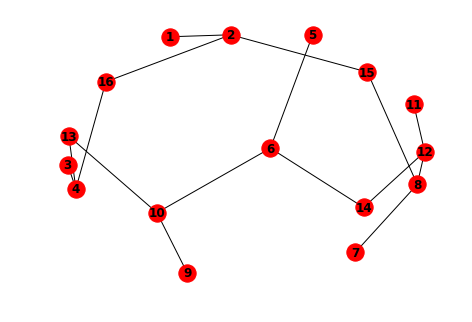

In [12]:
#plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [13]:
# Inputs
source = start_list  # Source node for route finding
#targets = G.nodes()  # Target nodes for route finding
#targets.remove(0)

targets = end_list  # Target nodes for route finding
print(targets)

[1, 3, 5, 7, 9]


In [14]:
# Create list of all paths to target nodes from source node
paths = {}
for target in targets:
    target_key = str(target)
    paths.update({target_key: []})
    #paths.update({target_key: {paths:[]}})
    for path in nx.all_simple_paths(G, source=source, target=target):
        #print(paths[target_key])
        paths[target_key].append({"source": source, "target": target, "path": path})

paths

{'1': [{'path': [11, 12, 14, 6, 10, 13, 4, 16, 2, 1],
   'source': 11,
   'target': 1},
  {'path': [11, 12, 8, 15, 2, 1], 'source': 11, 'target': 1}],
 '3': [{'path': [11, 12, 14, 6, 10, 13, 4, 3], 'source': 11, 'target': 3},
  {'path': [11, 12, 8, 15, 2, 16, 4, 3], 'source': 11, 'target': 3}],
 '5': [{'path': [11, 12, 14, 6, 5], 'source': 11, 'target': 5},
  {'path': [11, 12, 8, 15, 2, 16, 4, 13, 10, 6, 5],
   'source': 11,
   'target': 5}],
 '7': [{'path': [11, 12, 14, 6, 10, 13, 4, 16, 2, 15, 8, 7],
   'source': 11,
   'target': 7},
  {'path': [11, 12, 8, 7], 'source': 11, 'target': 7}],
 '9': [{'path': [11, 12, 14, 6, 10, 9], 'source': 11, 'target': 9},
  {'path': [11, 12, 8, 15, 2, 16, 4, 13, 10, 9], 'source': 11, 'target': 9}]}

In [15]:
# Create list of combinations of paths
path_combinations = []
for target in paths:
    #print(list(range(0, len(paths[target])+1)))
    path_combinations.append(list(range(0, len(paths[target]))))
    
path_combinations = list(product(*path_combinations))
path_combinations

[(0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1),
 (0, 0, 0, 1, 0),
 (0, 0, 0, 1, 1),
 (0, 0, 1, 0, 0),
 (0, 0, 1, 0, 1),
 (0, 0, 1, 1, 0),
 (0, 0, 1, 1, 1),
 (0, 1, 0, 0, 0),
 (0, 1, 0, 0, 1),
 (0, 1, 0, 1, 0),
 (0, 1, 0, 1, 1),
 (0, 1, 1, 0, 0),
 (0, 1, 1, 0, 1),
 (0, 1, 1, 1, 0),
 (0, 1, 1, 1, 1),
 (1, 0, 0, 0, 0),
 (1, 0, 0, 0, 1),
 (1, 0, 0, 1, 0),
 (1, 0, 0, 1, 1),
 (1, 0, 1, 0, 0),
 (1, 0, 1, 0, 1),
 (1, 0, 1, 1, 0),
 (1, 0, 1, 1, 1),
 (1, 1, 0, 0, 0),
 (1, 1, 0, 0, 1),
 (1, 1, 0, 1, 0),
 (1, 1, 0, 1, 1),
 (1, 1, 1, 0, 0),
 (1, 1, 1, 0, 1),
 (1, 1, 1, 1, 0),
 (1, 1, 1, 1, 1)]

In [16]:
# Create new graphs for each combination
final_graphs = []

# Loop for each path combination
for path_combination in path_combinations:
    #new_graphs = []
    new_graph = nx.Graph()
    # Loop for each target
    for target_number, target in enumerate(targets):
        #new_graphs.append(nx.Graph())
        edge_list = []
        
        #print(paths[str(target)])
        #print(path_combination[target_number]) 
        #print(paths[str(target)][path_combination[target_number]])
        #print('')
        
        my_path = paths[str(target)][path_combination[target_number]]['path']
        #print(my_path)
        # Loop for each node in path
        for i in range(0, len(my_path)-1):
            #print(my_path[i])
            #print(my_path[i+1])
            #print('')
            edge_list.append((my_path[i], my_path[i+1]))
        print(edge_list)
        print('')
        G1 = nx.Graph()
        G1.add_edges_from(edge_list)
        if target_number > 0:
            new_graph = nx.compose(G1, new_graph)
        
        #print(path_combination[target_number])
        #print(paths[str(target)][path_combination[target_number]]['path'])
    final_graphs.append(new_graph)
    
print(final_graphs)

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 13), (13, 4), (4, 16), (16, 2), (2, 1)]

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 13), (13, 4), (4, 3)]

[(11, 12), (12, 14), (14, 6), (6, 5)]

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 13), (13, 4), (4, 16), (16, 2), (2, 15), (15, 8), (8, 7)]

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 9)]

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 13), (13, 4), (4, 16), (16, 2), (2, 1)]

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 13), (13, 4), (4, 3)]

[(11, 12), (12, 14), (14, 6), (6, 5)]

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 13), (13, 4), (4, 16), (16, 2), (2, 15), (15, 8), (8, 7)]

[(11, 12), (12, 8), (8, 15), (15, 2), (2, 16), (16, 4), (4, 13), (13, 10), (10, 9)]

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 13), (13, 4), (4, 16), (16, 2), (2, 1)]

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 13), (13, 4), (4, 3)]

[(11, 12), (12, 14), (14, 6), (6, 5)]

[(11, 12), (12, 8), (8, 7)]

[(11, 12), (12, 14), (14, 6), (6, 10), (10, 9)]

[(11, 12)

In [17]:
print('number of graphs: ' + str(len(final_graphs)))

t_stop = time.time()
print('time elapsed: ' + str(t_stop - t_start))

number of graphs: 32
time elapsed: 0.6123874187469482


C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\jmcneill\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: 

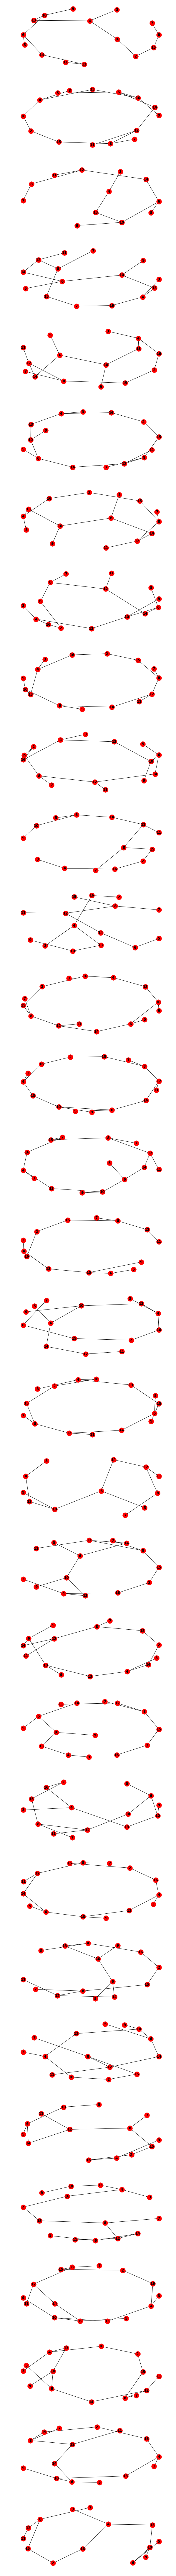

In [18]:
fig = plt.figure(figsize=(10, 5*(len(final_graphs))))
for i, F in enumerate(final_graphs):
    ax = fig.add_subplot(len(final_graphs),1,i+1)
    nx.draw(F, with_labels=True, font_weight='bold')

plt.show()


In [19]:
"""
# Find and remove closed loop solutions

# Determine closed loops
G = final_graphs[0]
DG = nx.DiGraph(G)
simple_cycles = list(nx.simple_cycles(DG))
simple_cycles = [x for x in simple_cycles if len(x) > 2]

for closed_loop in simple_cycles:
    # Loop for each node in path
    closed_loop_list = []
    closed_loop = simple_cycles[0]
    for i in range(0, len(closed_loop)-1):
        closed_loop_list.append((closed_loop[i], closed_loop[i+1]))
    closed_loop_list.insert(0, (0, 1))    

    # Remove graph if it matches cycle
    for i, final_graph in enumerate(final_graphs):
        #print(my_closed_loop)
        if final_graphs[i].edges() == closed_loop_list:
            final_graphs.remove(final_graph)
"""